데이터를 불러온다.

In [2]:
from torchvision.transforms.transforms import RandomHorizontalFlip
import torchvision.datasets as dsets
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(256),
                                transforms.RandomCrop(227),
                                transforms.RandomHorizontalFlip(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = dsets.CIFAR10(root='CIFAR10',
                           train=True,
                           transform=transform,
                           download=True)

test_data = dsets.CIFAR10(root='CIFAR10',
                           train=False,
                           transform=transform,
                           download=True)

Files already downloaded and verified
Files already downloaded and verified


train data 크기, 형태를 확인한다.

In [3]:
print('train data 개수:', len(train_data))
print(train_data[0])

train data 개수: 50000
(tensor([[[-0.8443, -0.8166, -0.7888,  ..., -0.0619, -0.0618, -0.0617],
         [-0.8241, -0.7945, -0.7649,  ..., -0.0650, -0.0642, -0.0633],
         [-0.8038, -0.7723, -0.7409,  ..., -0.0681, -0.0665, -0.0649],
         ...,
         [ 0.4451,  0.4529,  0.4608,  ...,  0.1581,  0.0676, -0.0229],
         [ 0.4225,  0.4324,  0.4422,  ...,  0.1868,  0.0984,  0.0100],
         [ 0.4000,  0.4118,  0.4235,  ...,  0.2155,  0.1292,  0.0429]],

        [[-0.9224, -0.9065, -0.8906,  ..., -0.3352, -0.3367, -0.3383],
         [-0.9119, -0.8945, -0.8771,  ..., -0.3376, -0.3385, -0.3394],
         [-0.9013, -0.8825, -0.8636,  ..., -0.3400, -0.3403, -0.3406],
         ...,
         [ 0.0797,  0.0964,  0.1130,  ..., -0.0990, -0.1882, -0.2775],
         [ 0.0543,  0.0725,  0.0907,  ..., -0.0794, -0.1667, -0.2539],
         [ 0.0289,  0.0487,  0.0685,  ..., -0.0598, -0.1451, -0.2304]],

        [[-0.9865, -0.9811, -0.9757,  ..., -0.5994, -0.6009, -0.6025],
         [-0.9841, -0.9

이미지를 출력해본다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


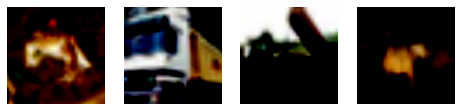

In [4]:
# train_data image 확인
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 4, figsize = (8, 2))

for i in range(4):
  img = train_data[i][0].numpy()
  axs[i].imshow(np.transpose(img, (1, 2, 0))) # 3, 224, 224 -> 224, 224, 3으로 size 변경
  axs[i].axis('off')


Dataloader를 생성한다.

In [5]:
from torch.utils.data import DataLoader

batch_size = 512
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Dataloader가 잘 생성되었는지 확인한다.












In [6]:
print(len(train_loader))

97


In [7]:
for x, y in train_loader:
  print(x[0], y[0])
  print('image size:', x[0].shape)
  break

tensor([[[ 0.0538,  0.0680,  0.0823,  ...,  0.5127,  0.5127,  0.5127],
         [ 0.0424,  0.0583,  0.0742,  ...,  0.5186,  0.5186,  0.5186],
         [ 0.0268,  0.0438,  0.0607,  ...,  0.5088,  0.5088,  0.5088],
         ...,
         [-0.2821, -0.2748, -0.2674,  ..., -0.4730, -0.4730, -0.4730],
         [-0.2895, -0.2831, -0.2767,  ..., -0.4740, -0.4740, -0.4740],
         [-0.2949, -0.2889, -0.2829,  ..., -0.4765, -0.4765, -0.4765]],

        [[-0.1286, -0.1205, -0.1124,  ...,  0.1559,  0.1559,  0.1559],
         [-0.1592, -0.1487, -0.1381,  ...,  0.1382,  0.1382,  0.1382],
         [-0.1780, -0.1659, -0.1538,  ...,  0.1172,  0.1172,  0.1172],
         ...,
         [ 0.0289,  0.0338,  0.0387,  ..., -0.0838, -0.0838, -0.0838],
         [ 0.0328,  0.0377,  0.0426,  ..., -0.0828, -0.0828, -0.0828],
         [ 0.0368,  0.0417,  0.0466,  ..., -0.0838, -0.0838, -0.0838]],

        [[-0.1725, -0.1745, -0.1765,  ..., -0.0319, -0.0319, -0.0319],
         [-0.1951, -0.1951, -0.1951,  ..., -0

GPU 설정을 해준다.

In [8]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1)
if device == 'cuda': torch.cuda.manual_seed_all(1)

AlexNet model을 제작한다.

In [9]:
import torch.nn as nn

class AlexNet(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.conv_layer = nn.Sequential(
        # First Conv & Pooling Layer (Input: 3*227*227 / using LRN)
        nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
        nn.ReLU(),
        nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
        nn.MaxPool2d(kernel_size=3, stride=2),

        # Second Conv & Pooling layer (Input: 96*27*27 / using LRN)
        nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
        nn.MaxPool2d(kernel_size=3, stride=2),
        # Output: 256*13*13
        
        # Third~Fifth Layer (Only Conv and ReLU)
        nn.Conv2d(256, 384, 3, padding=1),  
        nn.ReLU(),
        nn.Conv2d(384, 384, 3, padding=1),  
        nn.ReLU(),
        nn.Conv2d(384, 256, 3, padding=1),  
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2)
        # Output: 256*6*6
    )

    self.fc_layer = nn.Sequential(
        # using Dropout
        nn.Dropout(p=0.5),
        nn.Linear((256*6*6), 4096),
        nn.ReLU(),
        
        nn.Dropout(p=0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        # 10 is the number of classes
        nn.Linear(4096, 10)
    )

  def forward(self, x):
    out = self.conv_layer(x)
    out = out.view(-1, 256*6*6)
    out = self.fc_layer(out)
    return out
  
model = AlexNet().to(device)

In [10]:
import torch.optim as optim
from tqdm.auto import tqdm

learning_rate = 1e-2
momentum = 0.9
weight_decay = 0.0005

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

model.train()
epochs = 30
total_batch = len(train_loader)
for epoch in tqdm(range(epochs)):
  avg_cost = 0
  for x, y in train_loader:
    x = x.to(device)
    y = y.to(device)

    hypothesis = model(x)
    cost = criterion(hypothesis, y)

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    avg_cost += cost/total_batch
  
  print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

  0%|          | 0/30 [00:00<?, ?it/s]

[Epoch:    1] cost = 2.30263853
[Epoch:    2] cost = 2.30257511
[Epoch:    3] cost = 2.30242682
[Epoch:    4] cost = 2.30209684
[Epoch:    5] cost = 2.30107141
[Epoch:    6] cost = 2.29011297
[Epoch:    7] cost = 2.0791769
[Epoch:    8] cost = 1.88141537
[Epoch:    9] cost = 1.70846713
[Epoch:   10] cost = 1.60370219
[Epoch:   11] cost = 1.49882841
[Epoch:   12] cost = 1.43083096
[Epoch:   13] cost = 1.37867963
[Epoch:   14] cost = 1.32554245
[Epoch:   15] cost = 1.27198792
[Epoch:   16] cost = 1.22684884
[Epoch:   17] cost = 1.18115866
[Epoch:   18] cost = 1.12781942
[Epoch:   19] cost = 1.0690726
[Epoch:   20] cost = 1.03476226
[Epoch:   21] cost = 0.987695515
[Epoch:   22] cost = 0.94591397
[Epoch:   23] cost = 0.911079824
[Epoch:   24] cost = 0.863293827
[Epoch:   25] cost = 0.826832592
[Epoch:   26] cost = 0.820562541
[Epoch:   27] cost = 0.766789973
[Epoch:   28] cost = 0.74353689
[Epoch:   29] cost = 0.72291398
[Epoch:   30] cost = 0.687450588


모델의 성능을 확인한다.


In [11]:
model.eval()

with torch.no_grad():
  total_test = torch.Tensor([len(test_data)]).to(device)
  accuracy = torch.Tensor([0]).to(device)
  for x, y in test_loader:
    x = x.to(device)
    y = y.to(device)
    
    prediction = model(x)
    correct_prediction = torch.argmax(prediction, 1) == y
    accuracy += correct_prediction.long().sum() / total_test
  print('Accuracy:', accuracy.item())

Accuracy: 0.7683000564575195
